In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression

df = pd.read_csv('laptop_preprocess.csv')
df.head()

,Unnamed: 0,Price,Rating,OS,Warranty,Ram_GB,SSD_GB,Display_size_inch,Brand,GPU_Memory_GB,Core_Count,Core_Threads,Processor
0,0,50399,70.0,Windows 11,1.0,8,512,15.6,HP,4,6.0,12.0,AMD
1,1,23990,56.0,Windows 11,1.0,8,512,15.6,Tecno,0,2.0,4.0,Intel
2,2,26989,55.0,Windows 11,1.0,8,512,15.6,Lenovo,0,4.0,8.0,AMD
3,3,69990,60.0,Windows 11,1.0,16,512,13.3,Samsung,0,12.0,16.0,Intel
4,4,102990,78.0,Windows 11,1.0,16,1024,16.1,Xiaomi,8,24.0,32.0,Intel


In [2]:

X = df.copy().drop(columns='Warranty')#because warranty has 0 
y = X.pop('Rating')

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features= X.dtypes == int

X.shape

(920, 11)

In [3]:
def make_mi_scores(X, y, discrete_features):
    print(f"\n--- Debug inside make_mi_scores (Start of new checks) ---")

    # --- Y Conversion (as previously implemented - keep this) ---
    y_processed = y
    if y.ndim == 2 and y.shape[1] == 1:
        if isinstance(y, pd.DataFrame):
            y_processed = y.iloc[:, 0]
        else: # Assuming numpy array
            y_processed = y.ravel()
        print(f"Y converted. New y_processed shape: {y_processed.shape}, y_processed empty: {y_processed.empty}")
    elif y.ndim > 1:
        print(f"Warning: y has more than 1 dimension and is not (N,1). mutual_info_regression expects 1D or (N,1) for single output.")

    # --- CRITICAL CHECKS HERE (keep these for future debugging if needed) ---
    print(f"\n--- Post-conversion and Pre-MI Call Checks ---")
    print(f"X final shape: {X.shape}")
    print(f"y_processed final shape: {y_processed.shape}")
    if X.empty: raise ValueError("X is empty before MI calculation.")
    if y_processed.empty: raise ValueError("y_processed is empty before MI calculation.")
    if X.shape[0] != y_processed.shape[0]: raise ValueError(f"X and y_processed sample count mismatch: X has {X.shape[0]}, y has {y_processed.shape[0]}.")
    print(f"Total NaNs in X: {X.isnull().sum().sum()}")
    print(f"Total NaNs in y_processed: {y_processed.isnull().sum()}")
    all_nan_cols = X.columns[X.isnull().all()].tolist()
    print(f"Columns in X with ALL NaNs: {all_nan_cols}")
    if y_processed.isnull().all(): print(f"WARNING: y_processed is entirely NaNs!")
    print(f"X dtypes:\n{X.dtypes}")
    print(f"y_processed dtype: {y_processed.dtype}")
    object_cols_in_X = X.select_dtypes(include=['object']).columns.tolist()
    if object_cols_in_X:
        print(f"WARNING: X contains 'object' type columns: {object_cols_in_X}. Ensure they are correctly handled (e.g., encoded or made discrete).")

 # --- Discrete Features Mask Construction (REVISED PART) ---
    temp_discrete_features_mask = None # Use a temporary variable first

    if all(isinstance(f, str) for f in discrete_features):
        missing_cols = [col for col in discrete_features if col not in X.columns]
        if missing_cols:
            print(f"Warning: Discrete feature column names not found in X: {missing_cols}. These will be ignored.")
            temp_discrete_features_mask = X.columns.isin([col for col in discrete_features if col in X.columns])
        else:
            temp_discrete_features_mask = X.columns.isin(discrete_features)
    elif isinstance(discrete_features, (list, np.ndarray)) and all(isinstance(f, (bool, np.bool_)) for f in discrete_features):
        if len(discrete_features) != X.shape[1]:
            raise ValueError(f"Length of discrete_features ({len(discrete_features)}) must match number of columns in X ({X.shape[1]}).")
        temp_discrete_features_mask = discrete_features
    else:
        print("Warning: discrete_features format not recognized or empty. Assuming all features are continuous.")
        temp_discrete_features_mask = [False] * X.shape[1]

    # --- THE CRITICAL FIX: Convert to NumPy boolean array ---
    # Ensure temp_discrete_features_mask is a boolean numpy array for mutual_info_regression
    discrete_features_mask = np.asarray(temp_discrete_features_mask, dtype=bool)

     # --- Final check on discrete_features_mask ---
    print(f"Discrete features mask (bools, first 5): {discrete_features_mask[:5] if len(discrete_features_mask) > 5 else discrete_features_mask}...")
    print(f"Type of discrete_features_mask: {type(discrete_features_mask)}") # Should now be <class 'numpy.ndarray'>
    print(f"Dtype of discrete_features_mask: {discrete_features_mask.dtype}") # Should be 'bool'
    print(f"Number of True (discrete) features: {np.sum(discrete_features_mask)}")

    print(f"--- Debug inside make_mi_scores (End of new checks) ---\n")


    # --- THE ACTUAL MUTUAL_INFO_REGRESSION CALL ---
    mi_scores = mutual_info_regression(X, y_processed, discrete_features=discrete_features_mask)
    # ... rest of your function
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::3]  # show a few features with their MI scores




--- Debug inside make_mi_scores (Start of new checks) ---

--- Post-conversion and Pre-MI Call Checks ---
X final shape: (920, 11)
y_processed final shape: (920,)
Total NaNs in X: 0
Total NaNs in y_processed: 0
Columns in X with ALL NaNs: []
X dtypes:
Unnamed: 0             int64
Price                  int64
OS                     int64
Ram_GB                 int64
SSD_GB                 int64
Display_size_inch    float64
Brand                  int64
GPU_Memory_GB          int64
Core_Count           float64
Core_Threads         float64
Processor              int64
dtype: object
y_processed dtype: float64
Discrete features mask (bools, first 5): [False False False False False]...
Type of discrete_features_mask: <class 'numpy.ndarray'>
Dtype of discrete_features_mask: bool
Number of True (discrete) features: 0
--- Debug inside make_mi_scores (End of new checks) ---



Price                0.489036
Core_Count           0.288021
Display_size_inch    0.135300
Processor            0.023580
Name: MI Scores, dtype: float64

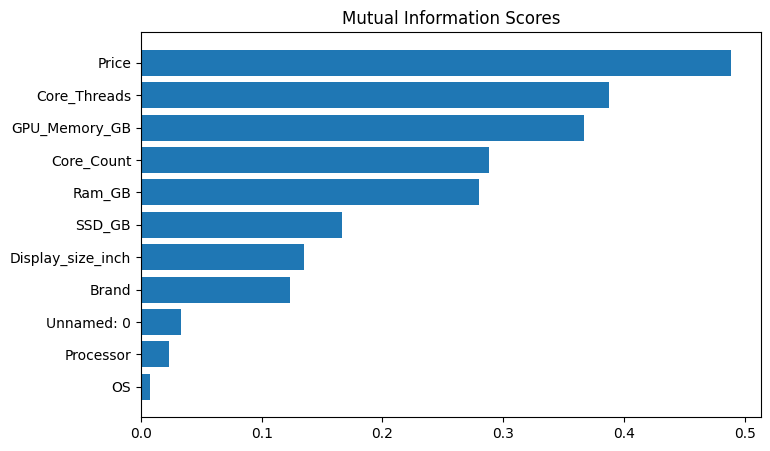

In [4]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [5]:
feature = ['Price','Core_Threads','GPU_Memory_GB','Core_Count','Ram_GB','SSD_GB','Display_size_inch','Brand']

X = df[feature]

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

y= y
X= X

model = DecisionTreeRegressor()

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 0)

s = (train_X.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['Brand']


In [7]:
from sklearn.preprocessing import OrdinalEncoder

# Make copy to avoid changing original data 
label_X_train = train_X.copy()
label_X_valid = val_X.copy()

# Apply ordinal encoder to each column with categorical data
ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=np.nan)
label_X_train[object_cols] = ordinal_encoder.fit_transform(train_X[object_cols])
label_X_valid[object_cols] = ordinal_encoder.transform(val_X[object_cols])

In [8]:
model.fit(label_X_train, train_y)
val_predictions = model.predict(label_X_valid)
print(mean_absolute_error(val_y, val_predictions))


3.445122848731885
